In [1]:
# Libs
import pandas as pd
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import re

In [2]:
# General
SEED = 42
random.seed(SEED)

# Loading Data

## Keypoints

In [3]:
df_kp = pd.read_feather("../Data/Cleaned/df_dta_kp_cleaned.feather")
print(df_kp.head())

   ID_kp  ID_dta                                          KEY_POINT
0      1      26          Need to spend long hours in the restroom.
1      2      27  Patients reported uncertainty about whether sy...
2      3      31  Intense fatigue and a permanent state of weakn...
3      4      36          Need to spend long hours in the restroom.
4      5      37          Need to spend long hours in the restroom.


## Questionnaire

In [4]:
df_kp_answers = pd.read_excel("../Data/Questionnaires_answers/Questionnaire_kp_answers.xlsx", engine='openpyxl')

Transpose the database.

In [5]:
df_kp_answers = df_kp_answers.T
df_kp_answers.columns = df_kp_answers.iloc[0].astype(str)
df_kp_answers = df_kp_answers[1:]
df_kp_answers.reset_index(inplace=True)

Rename the columns to more clear names.

In [6]:
df_kp_answers.rename(columns={
    'index': 'Question',
    '2025-04-28 10:32:43.897000': 'answer1',
    '2025-04-28 11:02:35.679000': 'answer2',
    '2025-04-30 11:17:45.719000': 'answer3'
}, inplace=True)

In [7]:
print(df_kp_answers.iloc[2])

Tijdstempel
Question    3/20\n\nKeypoint 1 (K1):\nStopping treatment w...
answer1                                                     2
answer2                                                     2
answer3                                                     3
Name: 2, dtype: object


In [8]:
print(df_kp_answers.at[2, 'Question'])

3/20

Keypoint 1 (K1):
Stopping treatment was seen as a sign of recovery, despite understanding the disease as incurable. 
Keypoint 2 (K2):
Includes purchases and adaptations related to long COVID that are not direct medical expenses or alternative therapies. Examples include buying an electric bicycle for limited physical capacity, purchasing protective equipment (e.g., masks), additional household costs, and increased transport costs (e.g., frequent medical visits). 


# Quick Analysis

## Keypoints

In [9]:
df_kp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID_kp      197 non-null    int32 
 1   ID_dta     197 non-null    int32 
 2   KEY_POINT  197 non-null    object
dtypes: int32(2), object(1)
memory usage: 3.2+ KB


## Questionnaire

In [10]:
df_kp_answers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  20 non-null     object
 1   answer1   20 non-null     object
 2   answer2   20 non-null     object
 3   answer3   20 non-null     object
dtypes: object(4)
memory usage: 768.0+ bytes


# Data Preprocessing

## Keypoints

Remove empty value.

In [11]:
df_kp = df_kp[df_kp['KEY_POINT'] != '']

Normalize all white spaces, just to be sure.

In [12]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', str(text))
    return text.strip().lower()

df_kp['KEY_POINT_normalized'] = df_kp['KEY_POINT'].apply(clean_text)

Normalize values.

In [13]:
df_kp['KEY_POINT_normalized'] = df_kp['KEY_POINT'].str.strip().str.replace('\n', ' ').str.replace('\r', ' ').str.lower()

Setting ID's for distinct keypoints to give the same score to the same keypoint.

In [14]:
df_kp['ID_kp_distinct'] = pd.factorize(df_kp['KEY_POINT'])[0]
print(df_kp.head(10))

   ID_kp  ID_dta                                          KEY_POINT  \
0      1      26          Need to spend long hours in the restroom.   
1      2      27  Patients reported uncertainty about whether sy...   
2      3      31  Intense fatigue and a permanent state of weakn...   
3      4      36          Need to spend long hours in the restroom.   
4      5      37          Need to spend long hours in the restroom.   
5      6      50  Stress stemmed from the fear of disease progre...   
6      7      50  Embarrassing situations caused by Crohn's, suc...   
7      8      50   Not psychologically prepared to manage such s...   
8      9      51  The ineffectiveness of prescribed treatments c...   
9     10      51  The sickness led to feelings of depression abo...   

                                KEY_POINT_normalized  ID_kp_distinct  
0          need to spend long hours in the restroom.               0  
1  patients reported uncertainty about whether sy...               1  
2  in

## Questionnaire

Change datatypes of the answers, and normalize.

In [15]:
df_kp_answers['answer1'] = df_kp_answers['answer1'].astype('Int64') - 3
df_kp_answers['answer2'] = df_kp_answers['answer2'].astype('Int64') - 3
df_kp_answers['answer3'] = df_kp_answers['answer3'].astype('Int64') - 3

Import ID's from the keypoints.

In [16]:
df_kp_answers['var1_label'] = None
df_kp_answers['var2_label'] = None

In [17]:
def kp_to_dist_idx(kp):
    try:
        kp_clean = kp.strip().replace('\n', ' ').replace('\r', ' ').lower()
        matching_rows = df_kp[df_kp['KEY_POINT_normalized'] == kp_clean]

        if not matching_rows.empty:
            return matching_rows['ID_kp_distinct'].iloc[0]
        else:
            print(f"Keypoint not found:\n{kp}")
            return None
    except Exception as e:
        print(f"Error finding keypoint:\n{kp}\n{e}")
        return None


for index, row in df_kp_answers.iterrows():
    parts = row['Question'].split("Keypoint 2 (K2):")
    kp1 = parts[0].split("Keypoint 1 (K1):")[1].strip()
    kp2 = parts[1].strip()

    idx1 = kp_to_dist_idx(kp1)
    idx2 = kp_to_dist_idx(kp2)
    
    df_kp_answers.at[index, 'var1_label'] = idx1
    df_kp_answers.at[index, 'var2_label'] = idx2

In [18]:
print(df_kp_answers.head())

Tijdstempel                                           Question  answer1  \
0            1/20\n\nKeypoint 1 (K1):\nLack of objective cr...       -2   
1            2/20\n\nKeypoint 1 (K1):\nNot psychologically ...        2   
2            3/20\n\nKeypoint 1 (K1):\nStopping treatment w...       -1   
3            4/20\n\nKeypoint 1 (K1):\nSub-optimal communic...       -1   
4            5/20\n\nKeypoint 1 (K1):\nVariety of symptoms ...       -1   

Tijdstempel  answer2  answer3 var1_label var2_label  
0                 -1       -1         73          5  
1                  2        2          5         69  
2                 -1        0         16         77  
3                 -1        1        114        121  
4                  0       -2         69        110  


In [19]:
# Test if this is correct
print((df_kp[df_kp['ID_kp_distinct'] == 73])['KEY_POINT'].head(1))
print((df_kp[df_kp['ID_kp_distinct'] == 5])['KEY_POINT'].head(1))
print((df_kp[df_kp['ID_kp_distinct'] == 69])['KEY_POINT'].head(1))

85    Lack of objective criteria to diagnose Long COVID
Name: KEY_POINT, dtype: object
7     Not psychologically prepared to manage such s...
Name: KEY_POINT, dtype: object
81    Variety of symptoms and uncertainties about lo...
Name: KEY_POINT, dtype: object


Get mean of the answers.

In [20]:
df_kp_answers['answer_mean'] = df_kp_answers[['answer1', 'answer2', 'answer3']].mean(axis=1)

Set 5-class to 3-class system. Why? -> less noise. (-1, 0, 1)

In [21]:
df_kp_answers['answer1_base3'] = None
df_kp_answers['answer2_base3'] = None
df_kp_answers['answer3_base3'] = None

def convert_5_to_3(value):
    if value in [-2, -1]:
        return -1
    elif value == 0:
        return 0
    elif value in [1, 2]:
        return 1
    else:
        print(f"Bad value!: {value}")
        return None

for index, row in df_kp_answers.iterrows():
    df_kp_answers.at[index, 'answer1_base3'] = convert_5_to_3(df_kp_answers.at[index, 'answer1'])
    df_kp_answers.at[index, 'answer2_base3'] = convert_5_to_3(df_kp_answers.at[index, 'answer2'])
    df_kp_answers.at[index, 'answer3_base3'] = convert_5_to_3(df_kp_answers.at[index, 'answer3'])
    df_kp_answers.at[index, 'answer_base3_mean'] = df_kp_answers[['answer1_base3', 'answer2_base3', 'answer3_base3']].iloc[index].mean()

In [22]:
print(df_kp_answers.head())

Tijdstempel                                           Question  answer1  \
0            1/20\n\nKeypoint 1 (K1):\nLack of objective cr...       -2   
1            2/20\n\nKeypoint 1 (K1):\nNot psychologically ...        2   
2            3/20\n\nKeypoint 1 (K1):\nStopping treatment w...       -1   
3            4/20\n\nKeypoint 1 (K1):\nSub-optimal communic...       -1   
4            5/20\n\nKeypoint 1 (K1):\nVariety of symptoms ...       -1   

Tijdstempel  answer2  answer3 var1_label var2_label  answer_mean  \
0                 -1       -1         73          5    -1.333333   
1                  2        2          5         69          2.0   
2                 -1        0         16         77    -0.666667   
3                 -1        1        114        121    -0.333333   
4                  0       -2         69        110         -1.0   

Tijdstempel answer1_base3 answer2_base3 answer3_base3  answer_base3_mean  
0                      -1            -1            -1          -1

# Analysing uncertainty in answers.

Get answer ranges.

In [23]:
df_kp_answers['answer_range'] = df_kp_answers[['answer1', 'answer2', 'answer3']].max(axis=1) - df_kp_answers[['answer1', 'answer2', 'answer3']].min(axis=1)
df_kp_answers['answer_base3_range'] = df_kp_answers[['answer1_base3', 'answer2_base3', 'answer3_base3']].max(axis=1) - df_kp_answers[['answer1_base3', 'answer2_base3', 'answer3_base3']].min(axis=1)

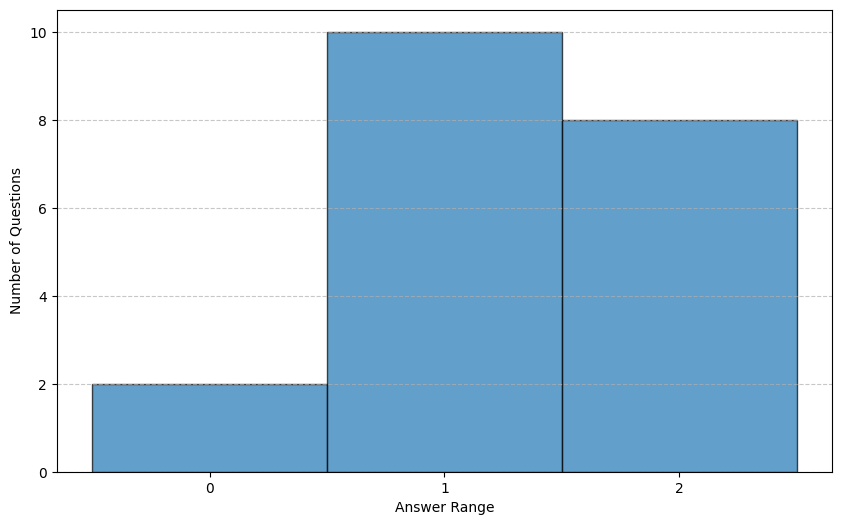

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(df_kp_answers['answer_range'].dropna(), bins=np.arange(-0.5, df_kp_answers['answer_range'].max() + 1.5, 1), edgecolor='black', alpha=0.7)
plt.xlabel("Answer Range")
plt.ylabel("Number of Questions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, df_kp_answers['answer_range'].max() + 1, 1))  # integers only
plt.show()

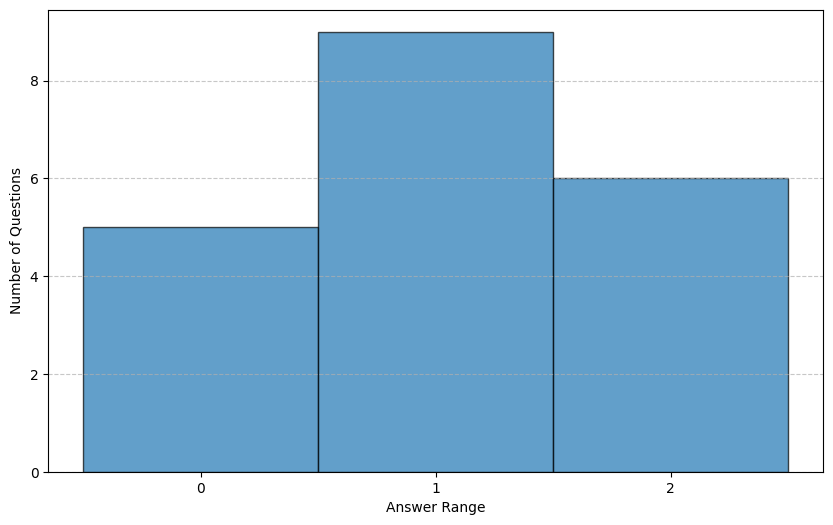

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(df_kp_answers['answer_base3_range'].dropna(), bins=np.arange(-0.5, df_kp_answers['answer_range'].max() + 1.5, 1), edgecolor='black', alpha=0.7)
plt.xlabel("Answer Range")
plt.ylabel("Number of Questions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, df_kp_answers['answer_range'].max() + 1, 1))  # integers only
plt.show()

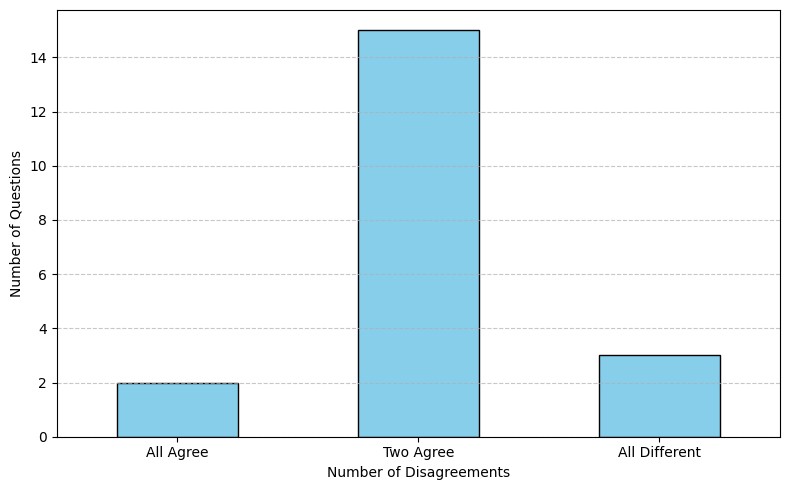

In [26]:
def count_disagreements(row):
    a = [row['answer1'], row['answer2'], row['answer3']]
    return len(set(a)) - 1

df_kp_answers['pairwise_disagreement'] = df_kp_answers.apply(count_disagreements, axis=1)
disagreement_counts = df_kp_answers['pairwise_disagreement'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
disagreement_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Number of Disagreements")
plt.ylabel("Number of Questions")
plt.xticks([0, 1, 2], ['All Agree', 'Two Agree', 'All Different'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

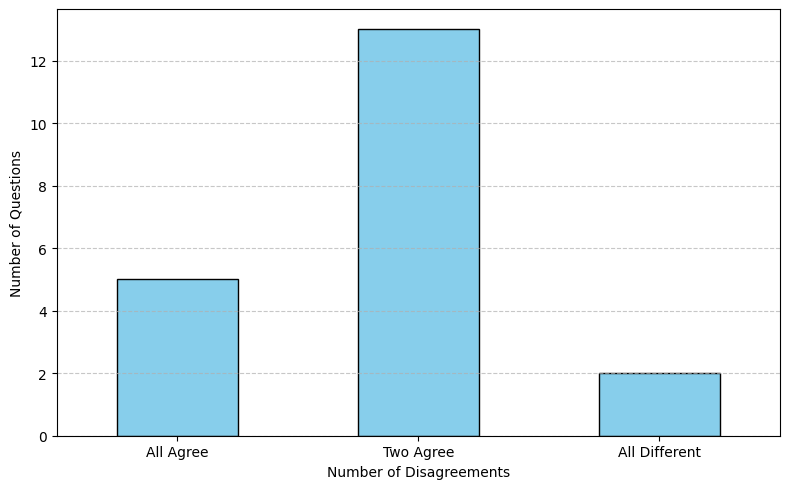

In [27]:
def count_disagreements(row):
    a = [row['answer1_base3'], row['answer2_base3'], row['answer3_base3']]
    return len(set(a)) - 1

df_kp_answers['pairwise_disagreement'] = df_kp_answers.apply(count_disagreements, axis=1)
disagreement_counts = df_kp_answers['pairwise_disagreement'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
disagreement_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Number of Disagreements")
plt.ylabel("Number of Questions")
plt.xticks([0, 1, 2], ['All Agree', 'Two Agree', 'All Different'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Pairwise comparisons to score

## Calculate net scores: 3

### Create Graph

Find keypoints with the same urgency. These cannot be implemented as different nodes in a graph. Otherwise we would get either a cyclical graph, or get nodes that cannot accurately calculate their maximum forward, and backward steps.

In [28]:
equivalent_keypoints = [] # First value in each array is the key of the node.

# Returns -1 if no equivalency already present, otherwise returns the index in the array.
def find_equivalence_index(label):
    for idx, group in enumerate(equivalent_keypoints):
        if label in group:
            return idx
    return -1

# Iterate trough all answers to identify equivalent nodes.
for index, row in df_kp_answers.iterrows():
    label1 = df_kp_answers.at[index, 'var1_label']
    label2 = df_kp_answers.at[index, 'var2_label']
    answer = df_kp_answers.at[index, 'answer_base3_mean']

    if answer == 0:
        idx1 = find_equivalence_index(label1)
        idx2 = find_equivalence_index(label2)

        if idx1 > -1 and idx2 > -1:
            if idx1 != idx2:
                # Merge two groups
                equivalent_keypoints[idx1].extend(equivalent_keypoints[idx2])
                equivalent_keypoints.pop(idx2)
        elif idx1 > -1:
            equivalent_keypoints[idx1].append(label2)
        elif idx2 > -1:
            equivalent_keypoints[idx2].append(label1)
        else:
            equivalent_keypoints.append([label1, label2])

print(str(equivalent_keypoints))

[[np.int64(3), np.int64(98)], [np.int64(96), np.int64(124)]]


Create graph

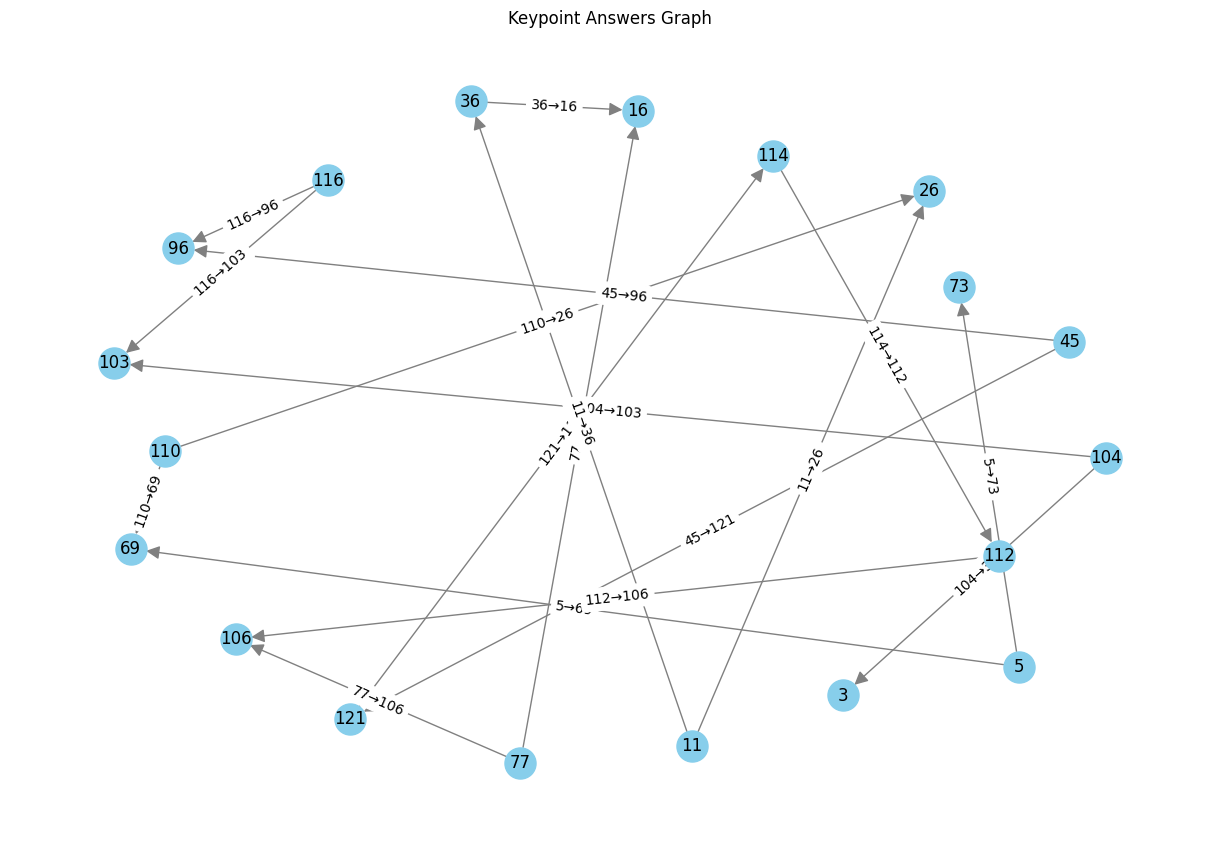

In [29]:
G = nx.DiGraph()

for index, row in df_kp_answers.iterrows():
    label1 = df_kp_answers.at[index, 'var1_label']
    label2 = df_kp_answers.at[index, 'var2_label']
    answer = df_kp_answers.at[index, 'answer_base3_mean']

    idx1 = find_equivalence_index(label1)
    idx2 = find_equivalence_index(label2)

    if idx1 > -1:
        label1 = equivalent_keypoints[idx1][0]
    if idx2 > -1:
        label2 = equivalent_keypoints[idx2][0]

    if answer < 0:
        G.add_edges_from([(str(label2), str(label1))])
    elif answer > 0:
        G.add_edges_from([(str(label1), str(label2))])
    # Not necessary to add edges with equivalent keypoints.
        

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=20)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, arrowsize=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{u}→{v}" for u, v in G.edges()})
plt.title("Keypoint Answers Graph")
plt.show()

It is essential that there are no cycles in the graph!

In [30]:
cycles = list(nx.simple_cycles(G))
print("Cycles found:")
for cycle in cycles:
    print(cycle)
if not cycles: print("None!")

Cycles found:
None!


### Calculate net-scores & transitive closure

In [31]:
def calculate_net_scores(G):
    TC = nx.transitive_closure(G)

    data = []
    for node in TC.nodes():
        out = len(list(TC.successors(node)))
        inc = len(list(TC.predecessors(node)))
        data.append((node, inc - out, out, inc))

    df_scores = pd.DataFrame(data, columns=['item','net_score', 'out', 'inc']).set_index('item')
    df_scores.index = df_scores.index.astype('int64')
    return df_scores


df_scores = calculate_net_scores(G)
print(df_scores)

      net_score  out  inc
item                     
5            -2    2    0
73            1    0    1
69            2    0    2
77           -2    2    0
16            3    0    3
121          -2    3    1
114           0    2    2
110          -2    2    0
116          -2    2    0
103           2    0    2
45           -5    5    0
112           2    1    3
26            2    0    2
36            0    1    1
106           5    0    5
96            2    0    2
104          -2    2    0
3             1    0    1
11           -3    3    0


## Simulate uncertainty (bootstrapping): 3-way comparison

### Helper functions

In [32]:
def build_graph_from_pairs(pairs):
    G = nx.DiGraph()
    
    for node1, node2, direction in pairs:
        if direction == 1:
            G.add_edge(str(node1), str(node2))
        elif direction == -1:
            G.add_edge(str(node2), str(node1))
            
    return G

In [33]:
def generate_random_graph(length=19, loop=False):
    graph_arr = np.arange(length)
    random.shuffle(graph_arr) # True order
    shuffled_graph = graph_arr.copy()
    random.shuffle(shuffled_graph)
    
    pairs = [] # Comparisons we have
    for i in range(length-1):
        node1 = shuffled_graph[i]
        node2 = shuffled_graph[i+1]
        
        direction = 0
        if np.where(graph_arr == node1)[0][0] > np.where(graph_arr == node2)[0][0]:
            direction = -1
        else:
            direction = 1
        
        pairs.append([node1, node2, direction])

    if loop:
        node1 = shuffled_graph[0]
        node2 = shuffled_graph[length-1]
        direction = 0
        if np.where(graph_arr == node1)[0][0] > np.where(graph_arr == node2)[0][0]:
            direction = -1
        else:
            direction = 1
        pairs.append([node1, node2, direction])
    
    G = build_graph_from_pairs(pairs)
    return G, graph_arr

### Bootstrapping for net scores distribution

In [34]:
net_scores = []

sim_len = 1000
arr_len = 19

for i in range(sim_len):
    G, actual_order = generate_random_graph(length=arr_len)
    net_scores_df = calculate_net_scores(G)
    new_net_scores = net_scores_df['net_score']
    net_scores.extend(new_net_scores)

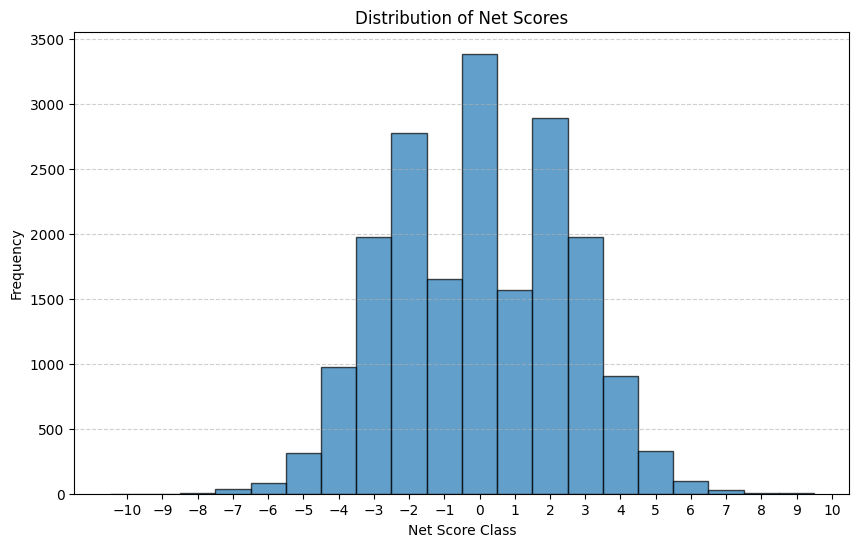

In [42]:
half_max_score = math.ceil(arr_len / 2)
bins = np.arange(-half_max_score, half_max_score+1, 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


counts, bin_edges = np.histogram(net_scores, bins=bins)
df = pd.DataFrame({'Class': bin_centers - 0.5, 'Count': counts})

plt.figure(figsize=(10, 6))
plt.bar(df['Class'], df['Count'], width=1, edgecolor='black', alpha=0.7)
plt.title("Distribution of Net Scores")
plt.xlabel("Net Score Class")
plt.ylabel("Frequency")
plt.xticks(np.arange(-half_max_score, half_max_score+1, 1))
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.show()

In [43]:
sorted_net_scores = np.sort(net_scores)

print(f"5th Percentile: {np.percentile(sorted_net_scores, 5)}")
print(f"33rd Percentile: {np.percentile(sorted_net_scores, 33)}")
print(f"50th Percentile: {np.percentile(sorted_net_scores, 50)}")
print(f"66th Percentile: {np.percentile(sorted_net_scores, 66)}")
print(f"95th Percentile: {np.percentile(sorted_net_scores, 95)}")

5th Percentile: -4.0
33rd Percentile: -1.0
50th Percentile: 0.0
66th Percentile: 1.0
95th Percentile: 4.0


### Bootstrapping for uncertainty of the predictions

In [44]:
def assign_actual_classes(ordered_array, num_classes):
    """
    Assign actual classes based on the ordered array, split into `num_classes` classes.
    """
    n = len(ordered_array)
    class_labels = {}

    chunk_size = n // num_classes
    for i, item in enumerate(ordered_array):
        class_num = i // chunk_size
        if class_num >= num_classes:
            class_num = num_classes - 1
        class_labels[item] = class_num
    
    return class_labels


def assign_predicted_classes_3(net_scores, cutoff=1):
    predicted_labels = []
    for score in net_scores:
        if score < -cutoff:
            predicted_labels.append(0)
        elif score > cutoff:
            predicted_labels.append(2)
        else:
            predicted_labels.append(1)
    return predicted_labels

def assign_predicted_classes_2(net_scores, cutoff):
    predicted_labels = []
    for score in net_scores:
        if score <= cutoff:
            predicted_labels.append(0)
        else:
            predicted_labels.append(1)
    return predicted_labels



In [45]:
accuracy = []

sim_len = 1000
arr_len = 19
num_classes = 2

for i in range(sim_len):
    G, actual_order = generate_random_graph(length=arr_len)
    net_scores_df = calculate_net_scores(G)
    new_net_scores = net_scores_df['net_score']
    
    actual_class_map = assign_actual_classes(actual_order, num_classes)
    predicted_labels = assign_predicted_classes_2(new_net_scores, cutoff=0)

    actual_labels = [actual_class_map[int(item)] for item in net_scores_df.index]
    correct = sum(a == p for a, p in zip(actual_labels, predicted_labels))
    acc = correct / arr_len
    accuracy.append(acc)

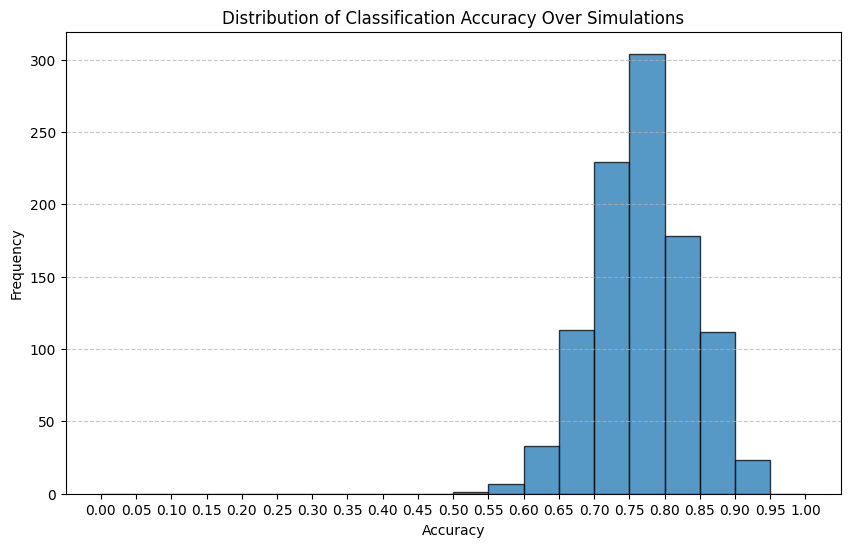

In [46]:
plt.figure(figsize=(10, 6))
plt.hist(accuracy, bins=20, range=(0, 1), edgecolor='black', alpha=0.75)
plt.title("Distribution of Classification Accuracy Over Simulations")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks([i/20 for i in range(0, 21)])

plt.show()

In [47]:
print(np.mean(accuracy))
print(np.std(accuracy))

0.7833684210526315
0.07320415046586747


## Calculate net scores: 5

### Create Graph

In [ ]:
# We already have the equivalent keypoints
print(str(equivalent_keypoints))

In [ ]:
G = nx.DiGraph()


for index, row in df_kp_answers.iterrows():
    label1 = df_kp_answers.at[index, 'var1_label']
    label2 = df_kp_answers.at[index, 'var2_label']
    answer = df_kp_answers.at[index, 'answer_mean']

    idx1 = find_equivalence_index(label1)
    idx2 = find_equivalence_index(label2)

    if idx1 > -1:
        label1 = equivalent_keypoints[idx1][0]
    if idx2 > -1:
        label2 = equivalent_keypoints[idx2][0]

    if answer < 0:
        G.add_edges_from([(str(label2), str(label1))])
    elif answer > 0:
        G.add_edges_from([(str(label1), str(label2))])
    # Not necessary to add edges with equivalent keypoints.
        

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=20)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, arrowsize=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{u}→{v}" for u, v in G.edges()})
plt.title("Keypoint Answers Graph")
plt.show()

### Calculate net-scores & transitive closure

## Simulate uncertainty (bootstrapping): 5-way comparison

### Helper functions

In [ ]:
#TODO

In [ ]:
def generate_random_graph_5(length=19, loop=False):
    graph_arr = np.arange(length)
    random.shuffle(graph_arr) # True order
    shuffled_graph = graph_arr.copy()
    random.shuffle(shuffled_graph)
    
    pairs = [] # Comparisons we have
    for i in range(length-1):
        node1 = shuffled_graph[i]
        node2 = shuffled_graph[i+1]
        
        direction = 0
        if np.where(graph_arr == node1)[0][0] > np.where(graph_arr == node2)[0][0]:
            direction = -1
        else:
            direction = 1
        
        pairs.append([node1, node2, direction])

    if loop:
        node1 = shuffled_graph[0]
        node2 = shuffled_graph[length-1]
        direction = 0
        if np.where(graph_arr == node1)[0][0] > np.where(graph_arr == node2)[0][0]:
            direction = -1
        else:
            direction = 1
        pairs.append([node1, node2, direction])
    
    G = build_graph_from_pairs(pairs)
    return G, graph_arr

### Bootstrapping for net score distribution

### Bootstrapping for uncertainty of the prediction

# Export Labeled Data

## Label Data

In [48]:
df_scores['label'] = assign_predicted_classes_2(df_scores['net_score'], cutoff=0)

## Create Labeled <-> Unlabeled Data

In [49]:
df_kp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 196
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID_kp                 196 non-null    int32 
 1   ID_dta                196 non-null    int32 
 2   KEY_POINT             196 non-null    object
 3   KEY_POINT_normalized  196 non-null    object
 4   ID_kp_distinct        196 non-null    int64 
dtypes: int32(2), int64(1), object(2)
memory usage: 7.7+ KB


In [50]:
df_scores.index

Index([  5,  73,  69,  77,  16, 121, 114, 110, 116, 103,  45, 112,  26,  36,
       106,  96, 104,   3,  11],
      dtype='int64', name='item')

In [51]:
df_kp_tmp = df_kp.drop_duplicates(subset='ID_kp_distinct', keep='first')

In [52]:
df_kp_labeled = df_kp_tmp[df_kp_tmp['ID_kp_distinct'].isin(df_scores.index)].copy()
df_kp_unlabeled = df_kp_tmp[~df_kp_tmp['ID_kp_distinct'].isin(df_scores.index)]

df_kp_labeled.loc[:, 'label'] = df_kp_labeled['ID_kp_distinct'].map(df_scores['label'])
print(df_kp_labeled)

     ID_kp  ID_dta                                          KEY_POINT  \
5        6      50  Stress stemmed from the fear of disease progre...   
7        8      50   Not psychologically prepared to manage such s...   
15      16      54  Not psychologically prepared to manage these s...   
23      24      60  Stopping treatment was seen as a sign of recov...   
34      35      68  The expertise of GPs familiar with Crohn's cou...   
44      45      71  Importance of how doctors communicate the CD d...   
53      54      73  Expenses also included food supplements like p...   
81      82     119  Variety of symptoms and uncertainties about lo...   
85      86     120  Lack of objective criteria to diagnose Long COVID   
89      90     121  Includes purchases and adaptations related to ...   
161    162     165  The invisibility of treatment effectiveness ca...   
172    173     168     Need for clear and understandable information.   
173    174     169  The decision to seek medical he

## Export

In [53]:
df_kp_labeled = df_kp_labeled.reset_index(drop=True)
df_kp_unlabeled = df_kp_unlabeled.reset_index(drop=True)

df_kp_labeled.to_feather('../Data/TrainingData/df_kp_labeled.feather')
df_kp_unlabeled.to_feather('../Data/TrainingData/df_kp_unlabeled.feather')